#Generating plots for paper

This notebook generates all plots related to Experiment 2 in the paper (called experiment_9 in code).

I fit a tanh model to performance as a function of patch size.

In [1]:
import os
import pickle
import pystan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_helpers as helpers
import yaml
from scipy.stats import spearmanr


# put figs together using svgutils (see http://neuroscience.telenczuk.pl/?p=331)
import svgutils.transform as sg

%matplotlib inline

# set some styles we like:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_palette("deep")


# set up the figure path:
top_dir = helpers.project_directory()
fig_dir = os.path.join(top_dir, 'figures')

experiment_num = 9
model_name = 'tanh3'

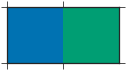

In [2]:
# color palette we like:
with open('plot_palette.yaml', 'r') as f:
    params = yaml.load(f)

# pal = sns.color_palette(params['pal'])
pal = sns.color_palette('colorblind', 2)
sns.palplot(pal)

In [3]:
# load unprocessed data, determine eye movement discarding:
dat = pd.read_csv(os.path.join(top_dir, 'results', 
                               ('experiment-' + str(experiment_num)), 
                               'all_data.csv'), index_col=False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15282 entries, 0 to 15281
Data columns (total 24 columns):
cond               15282 non-null object
surround_cond      15282 non-null object
surround_source    15282 non-null object
oddball            15282 non-null int64
im_code            15282 non-null object
target_loc         15282 non-null int64
jitter_1           15282 non-null float64
jitter_2           15282 non-null float64
jitter_3           15282 non-null float64
subj               15282 non-null object
session            15282 non-null int64
eccent             15282 non-null int64
patch_size_px      15282 non-null int64
scale              15282 non-null float64
test_location      15282 non-null object
rand_seed          15282 non-null float64
trial              15282 non-null int64
response           15282 non-null object
rt                 15240 non-null float64
correct            15240 non-null float64
eye_invalid        15040 non-null float64
eye_sd_deg         14944 non

In [4]:
dat.groupby(['subj']).eye_invalid.sum() / dat.groupby(['subj']).eye_invalid.size()

subj
S1    0.002714
S2    0.380293
S7    0.154180
S8    0.210641
S9    0.091575
dtype: float64

In [5]:
dat.time_invalid.sum()

29.0

In [6]:
dat.time_invalid.sum() / dat.time_invalid.size

0.0018976573746891769

In [7]:
processed = helpers.experiment_9_data_ready_for_analysis(dat)
processed.groupby(['subj']).size()

subj
S1    3674
S2    2283
S7    3116
S8    2908
dtype: int64

In [8]:
# load data from fit:
with open (os.path.join(top_dir, 'results', ('experiment-' + str(experiment_num)), 
                        ('expt_' + str(experiment_num) + '_' + 
                         model_name + '_full_model_fit.pkl')), 'rb') as f:
    stan_model, fit, plot_df, param_df, pop_param_df = pickle.load(f)

In [9]:
# print(fit)

# All subject data with model fits

In [10]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237768 entries, 0 to 237767
Data columns (total 14 columns):
ci_max         168 non-null float64
ci_min         168 non-null float64
cond           237768 non-null object
error_max      168 non-null float64
error_min      168 non-null float64
n_successes    168 non-null float64
n_trials       168 non-null float64
patch_size     237768 non-null float64
prop_corr      168 non-null float64
sample         237600 non-null float64
subj           237768 non-null object
subj_num       237768 non-null int64
surround       237768 non-null object
yhat           237600 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 27.2+ MB


In [11]:
# relabel cond so that legend looks nicer:
plot_df.loc[plot_df['cond'] == 'nat_v_synth', 'cond'] = 'nat vs synth'
plot_df.loc[plot_df['cond'] == 'synth_v_synth', 'cond'] = 'synth vs synth'

In [12]:
def plot_chance(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 12.5), (0.33, 0.33), ls='--', color='0.7')
    
def plot_preds(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, sample_col = args
    for i in range(n_samples):
        x = data.loc[data[sample_col]==i, x_col]
        y = data.loc[data[sample_col]==i, y_col]
        kwargs['marker'] = None
        plt.plot(x, y, **kwargs)

def plot_errors(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, mask_on = args

#     mask = np.isnan(data[mask_on])    
#     errors = np.vstack([data.loc[mask, 'error_min'], 
#                         data.loc[mask, 'error_max']])
#     print(np.unique(data.loc[mask, 'patch_size']))
#     plt.errorbar(data.loc[mask, x_col], 
#                  data.loc[mask, y_col], 
#                  yerr=errors,
#                  mew=1,
#                  capsize=0,
#                  **kwargs);        

    # plot downsampled points:
    mask = (np.isnan(data[mask_on]) & \
            ((data['patch_size'] == 4.47) | \
             (data['patch_size'] == 8.93)))
            
    errors = np.vstack([data.loc[mask, 'error_min'], 
                        data.loc[mask, 'error_max']])

    plt.errorbar(data.loc[mask, x_col], 
                 data.loc[mask, y_col], 
                 yerr=errors,
                 mew=1,
                 mec='k',
                 capsize=0,
                 **kwargs);                    
    
    # plot normal points:
    mask = (np.isnan(data[mask_on]) & \
            ((data['patch_size'] != 4.47) & \
             (data['patch_size'] != 8.93)))
            
    errors = np.vstack([data.loc[mask, 'error_min'], 
                        data.loc[mask, 'error_max']])

    plt.errorbar(data.loc[mask, x_col], 
                 data.loc[mask, y_col], 
                 yerr=errors,
                 mew=1,
                 mec='w',
                 capsize=0,
                 **kwargs);                

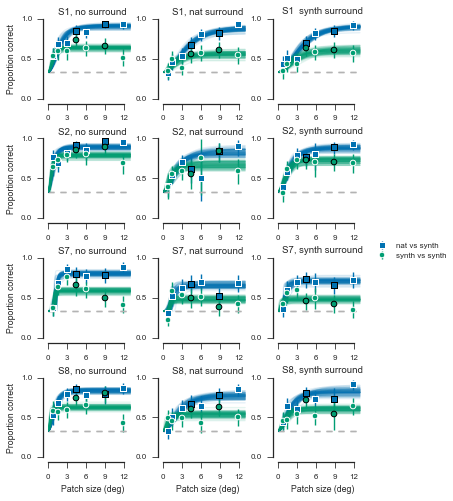

In [13]:
# plot:
n_samples = 100

g = sns.FacetGrid(plot_df, col='surround', row='subj', hue='cond', hue_kws={'marker': ['s', 'o']},
                  dropna=False,
                  palette=pal,
                  size=7./4)
g.map_dataframe(plot_chance)
g.map_dataframe(plot_preds, 'patch_size', 'yhat', 'sample', 
                alpha=0.1)
g.map_dataframe(plot_errors, 'patch_size', 'prop_corr', 'yhat',
                linestyle='none')
g.set_axis_labels('Patch size (deg)', 'Proportion correct')
g.set(xticks=np.linspace(0, 12, num=5), yticks=np.linspace(0, 1, num=3))
g.add_legend(title='')

# default facet titles:
# for ax in g.axes.flat:
#     print(ax.get_title())
# subj = S1 | surround = blank
# subj = S1 | surround = nat
# subj = S1 | surround = synth
# subj = S2 | surround = blank
# subj = S2 | surround = nat
# subj = S2 | surround = synth
# subj = S7 | surround = blank
# subj = S7 | surround = nat
# subj = S7 | surround = synth
# subj = S8 | surround = blank
# subj = S8 | surround = nat
# subj = S8 | surround = synth


# set shorter titles for facets:
titles = ["S1, no surround",
          "S1, nat surround",
          "S1  synth surround",
          "S2, no surround",
          "S2, nat surround",
          "S2, synth surround",
          "S7, no surround",
          "S7, nat surround",
          "S7, synth surround",
          "S8, no surround",
          "S8, nat surround",
          "S8, synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.3, hspace=0.5)
sns.despine(offset=5, trim=True);

In [14]:
g.fig.get_size_inches()

array([ 6.35,  7.  ])

In [15]:
g.fig.set_figwidth(7)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_observer_fits.pdf'), bbox_inches='tight')

# Parameter posteriors (multipanel plot)

## Critical stim level

In [16]:
# melt this into a tidy frame:
melted = pd.melt(param_df, id_vars=['subj','surround', 'cond', 'sample'],
                 var_name='param',
                 value_name='value')
melted.head()

,subj,surround,cond,sample,param,value
0,S1,blank,nat_v_synth,0,alpha,4.393992
1,S1,blank,synth_v_synth,0,alpha,2.121157
2,S1,nat,nat_v_synth,0,alpha,4.101058
3,S1,nat,synth_v_synth,0,alpha,1.720174
4,S1,synth,nat_v_synth,0,alpha,4.486615


In [17]:
np.unique(melted['param'])

array(['alpha', 'beta', 'critical_scale', 'prior_alpha', 'prior_beta',
       'prior_critical_scale'], dtype=object)

In [18]:
# plot absolute parameter values:
def plot_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    pos = np.array([2.])
    
    # for each subject:
    for s in np.unique(data['subj']):
        if np.any(data['cond']=='nat_v_synth'):
            this_pos = pos - 0.5
        else:
            this_pos = pos + 0.5
        
        # crop data to 95% middle:
        x = data.loc[data['subj'] == s, 'value'].values
        x = x[x >= np.percentile(x, 2.5)]
        x = x[x <= np.percentile(x, 97.5)]
        
        # stupid violinplot color setting:
        # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
        result = plt.violinplot(x, this_pos, 
                                showmeans=False,
                                showmedians=True,
                                showextrema=False,
                                widths=1.)
        for patch in result['bodies']: 
            patch.set_color(kwargs['color'])
            patch.set_label(kwargs['label'])
            patch.set_alpha(kwargs['alpha'])

        # set colour of mean:
#         result['cmeans'].set_color('k')
#         result['cmeans'].set_alpha(kwargs['alpha'])
        result['cmedians'].set_color('k')
        result['cmedians'].set_alpha(kwargs['alpha'])


        # increment the position:
        pos += 4


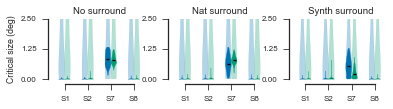

In [19]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_critical_scale', alpha=0.3)
g.map_dataframe(plot_violins, 'critical_scale', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[0, 2.5])
g.set(yticks=np.linspace(0, 2.5, num=3))

titles = ["No surround",
          "Nat surround",
          "Synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical size (deg)')
sns.despine(offset=5, trim=True);

In [20]:
g.fig.get_size_inches()

array([ 5.25,  1.75])

In [21]:
g.fig.set_figwidth(5.25)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.svg'), bbox_inches='tight')

## Same for gain parameters

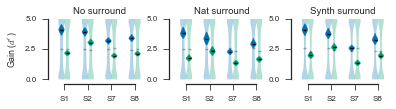

In [22]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_alpha', alpha=0.3)
g.map_dataframe(plot_violins, 'alpha', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 5, num=3))

titles = ["No surround",
          "Nat surround",
          "Synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Gain ($d^\prime$)')
sns.despine(offset=5, trim=True);

In [23]:
g.fig.set_figwidth(5.25)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.svg'), bbox_inches='tight')


## Same for slope

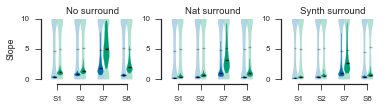

In [24]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=3.5/2)
g.map_dataframe(plot_violins, 'prior_beta', alpha=0.3)
g.map_dataframe(plot_violins, 'beta', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 10, num=3))

titles = ["No surround",
          "Nat surround",
          "Synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=5, trim=True);

In [25]:
g.fig.set_figwidth(5.25)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.svg'), bbox_inches='tight')


[ 5.25  1.75]


### Assemble multipanel figure using svgutils

See e.g. http://neuroscience.telenczuk.pl/?p=331

In [26]:
# create new SVG figure
fig = sg.SVGFigure("5.25in", "5.25in")

# load matpotlib-generated figures
fig1 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.svg'))
fig2 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                                model_name + '_params_gain.svg'))
fig3 = sg.fromfile(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                                model_name + '_params_slope.svg'))

# set size of composite based on panels (for some reason they aren't as saved):
w, h = fig1.get_size()
print(w, h)

# fig = sg.SVGFigure('514pt', '453pt')
# fig = sg.SVGFigure('514pt', '453pt')

fig1.set_size(('7in', '2.33in'))
fig2.set_size(('7in', '2.33in'))
fig3.set_size(('7in', '2.33in'))

sep = 111
sep2 = 15

# get the plot objects
plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(0, sep)
plot3.moveto(0, sep*2)

# add text labels
txt1 = sg.TextElement(5, sep2, "A", size=12, weight="bold")
txt2 = sg.TextElement(5, sep + sep2, "B", size=12, weight="bold")
txt3 = sg.TextElement(5, sep * 2 + sep2, "C", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3])
fig.append([txt1, txt2, txt3])

# save generated SVG files
fig.save(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_params_multipanel.svg'))

392pt 110pt


I don't know why the size of the subplots is not respected. Will have to manually resize in inkscape.

# Difference scores for parameters for surround conditions

In [27]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576000 entries, 0 to 575999
Data columns (total 6 columns):
subj        576000 non-null object
surround    576000 non-null object
cond        576000 non-null object
sample      576000 non-null int64
param       576000 non-null object
value       576000 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 30.8+ MB


In [28]:
grouped = melted.groupby(['subj', 'cond', 'param', 'sample'], as_index=False)

In [29]:
np.unique(melted['surround'])

array(['blank', 'nat', 'synth'], dtype=object)

In [30]:
def compute_diff_1(x):
    """compute the difference between 
    no surround and nat surround
    """
    a = x.loc[x['surround'] == 'blank', 'value']
    b = x.loc[x['surround'] == 'nat', 'value']
    return float(a.values - b.values)


def compute_diff_2(x):
    """compute the difference between 
    no surround and synth surround
    """
    a = x.loc[x['surround'] == 'blank', 'value']
    b = x.loc[x['surround'] == 'synth', 'value']
    return float(a.values - b.values)


def compute_diff_3(x):
    """compute the difference between 
    nat and synth surround
    """
    a = x.loc[x['surround'] == 'nat', 'value']
    b = x.loc[x['surround'] == 'synth', 'value']
    return float(a.values - b.values)


In [31]:
diff_1 = grouped.apply(compute_diff_1)
diff_1 = diff_1.reset_index(name='value')
diff_1['diff'] = 'blank - nat'

In [32]:
diff_2 = grouped.apply(compute_diff_2)
diff_2 = diff_2.reset_index(name='value')
diff_2['diff'] = 'blank - synth'

In [33]:
diff_3 = grouped.apply(compute_diff_3)
diff_3 = diff_3.reset_index(name='value')
diff_3['diff'] = 'nat - synth'

In [34]:
diffs = diff_1
diffs = diffs.append([diff_2, diff_3], ignore_index=True)

In [35]:
def plot_zero(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 14), (0, 0), ls='-', color='0.7', alpha=0.6)


### Critical scale differences

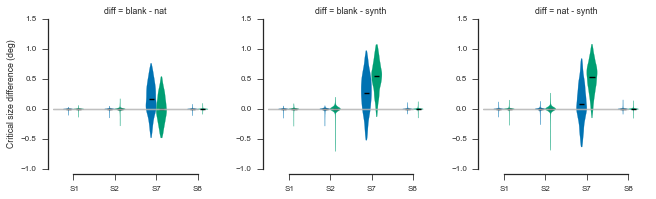

In [36]:
g = sns.FacetGrid(diffs, hue='cond',
                  col='diff',
                  palette=pal,
                  size=3)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'critical_scale', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
# g.set(ylim=[-2, 2])
# g.set(yticks=[-2, 0, 2])

g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical size difference (deg)')
sns.despine(offset=5, trim=True);

In [37]:
g.fig.set_figwidth(5)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_critical_scale_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_critical_scale_difference.svg'), bbox_inches='tight')


[ 5.  3.]


### Gain

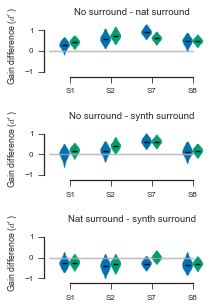

In [38]:
g = sns.FacetGrid(diffs, hue='cond',
                  row='diff',
                  palette=pal,
                  aspect=2,
                  size=1.5)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'alpha', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[-1, 1.5])
g.set(yticks=[-1, 0, 1])

titles = ["No surround - nat surround",
          "No surround - synth surround",
          "Nat surround - synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


g.fig.subplots_adjust(hspace=1)
g.set_axis_labels('', 'Gain difference ($d^\prime$)')
sns.despine(offset=5, trim=True);

In [39]:
g.fig.set_figwidth(3)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_gain_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_gain_difference.svg'), bbox_inches='tight')


[ 3.   4.5]


### Slope differences

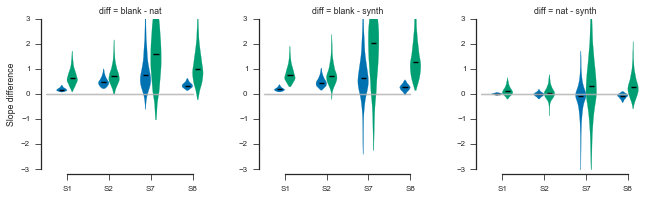

In [40]:
g = sns.FacetGrid(diffs, hue='cond',
                  col='diff',
                  palette=pal,
                  size=3)
g.map_dataframe(plot_zero)
g.map_dataframe(plot_violins, 'beta', alpha=1)
g.set(xticks=[2., 6., 10., 14.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[-3, 3])
# g.set(yticks=[-1.5, -1, 0, 1, 1.5])

g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope difference')
sns.despine(offset=5, trim=True);

In [41]:
g.fig.set_figwidth(5)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_slope_difference.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_slope_difference.svg'), bbox_inches='tight')


[ 5.  3.]


## Export point estimates of parameters across conditions

Apply an ANOVA-style analysis using JASP.


In [42]:
melted.head()

,subj,surround,cond,sample,param,value
0,S1,blank,nat_v_synth,0,alpha,4.393992
1,S1,blank,synth_v_synth,0,alpha,2.121157
2,S1,nat,nat_v_synth,0,alpha,4.101058
3,S1,nat,synth_v_synth,0,alpha,1.720174
4,S1,synth,nat_v_synth,0,alpha,4.486615


In [43]:
# reduce mcmc samples to point estimates:
pe = melted.groupby(['subj', 'surround', 'cond', 'param'], as_index=False).value.agg({'median': np.median,
                                                                                      'mean': np.mean})

# not interested in priors:
mask = (pe['param'] != 'prior_alpha') & \
       (pe['param'] != 'prior_beta') & \
       (pe['param'] != 'prior_critical_scale')
pe = pe.loc[mask, :]

In [44]:
pe.head()

,subj,surround,cond,param,mean,median
0,S1,blank,nat_v_synth,alpha,4.093943,4.096494
1,S1,blank,nat_v_synth,beta,0.363144,0.352481
2,S1,blank,nat_v_synth,critical_scale,0.009899,0.001018
6,S1,blank,synth_v_synth,alpha,2.161066,2.160809
7,S1,blank,synth_v_synth,beta,1.195884,1.110919


In [45]:
# pivot the frame around to have one subject per row:
out = pd.pivot_table(pe, 
                     index=['subj'], 
                     columns=['param', 'surround', 'cond'], 
                     values=['median', 'mean'])

# rename column names (from https://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns)
out.columns = ['_'.join(col).strip() for col in out.columns.values]
out

,mean_alpha_blank_nat_v_synth,mean_alpha_blank_synth_v_synth,mean_alpha_nat_nat_v_synth,mean_alpha_nat_synth_v_synth,mean_alpha_synth_nat_v_synth,mean_alpha_synth_synth_v_synth,mean_beta_blank_nat_v_synth,mean_beta_blank_synth_v_synth,mean_beta_nat_nat_v_synth,mean_beta_nat_synth_v_synth,...,median_beta_nat_nat_v_synth,median_beta_nat_synth_v_synth,median_beta_synth_nat_v_synth,median_beta_synth_synth_v_synth,median_critical_scale_blank_nat_v_synth,median_critical_scale_blank_synth_v_synth,median_critical_scale_nat_nat_v_synth,median_critical_scale_nat_synth_v_synth,median_critical_scale_synth_nat_v_synth,median_critical_scale_synth_synth_v_synth
subj,,,,,,,,,,,,,,,,,,,,,
S1,4.093943,2.161066,3.825349,1.750757,4.105243,1.997821,0.363144,1.195884,0.175972,0.482895,...,0.174206,0.434119,0.164540,0.328706,0.001018,0.001156,0.000973,0.001199,0.000844,0.000569
S2,3.924438,3.043852,3.354437,2.325085,3.775636,2.646824,0.843384,1.501956,0.334591,0.712580,...,0.324217,0.646819,0.338908,0.598591,0.001928,0.002684,0.002030,0.002704,0.001929,0.001800
S7,3.177663,1.945030,2.274189,1.343346,2.569108,1.347746,2.413239,5.325675,1.474685,3.721943,...,0.984930,3.126697,1.087156,2.623205,0.826045,0.784153,0.650373,0.788979,0.538374,0.213293
S8,3.405067,2.115576,2.955373,1.647546,3.299809,1.959890,0.647555,2.340711,0.297373,1.197475,...,0.289523,0.992425,0.369605,0.680694,0.001153,0.001175,0.001065,0.001235,0.000817,0.000643


In [46]:
# save to csv for analysis in JASP:
out.to_csv(os.path.join(top_dir, 'results', 
                        'experiment-{}'.format(experiment_num), 'point_estimates.csv'))

## How does the population mu change from prior to posterior?

With only four subjects, probably not much.

In [47]:
pop_param_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 5
Data columns (total 9 columns):
surround                   24000 non-null object
cond                       24000 non-null object
sample                     24000 non-null int64
mu_alpha                   24000 non-null float64
mu_beta                    24000 non-null float64
mu_critical_scale          24000 non-null float64
prior_mu_alpha             24000 non-null float64
prior_mu_beta              24000 non-null float64
prior_mu_critical_scale    24000 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.8+ MB


In [48]:
pop_melted = pd.melt(pop_param_df, id_vars=['surround', 'cond', 'sample'],
                 var_name='param',
                 value_name='value')
pop_melted.head()

,surround,cond,sample,param,value
0,blank,nat_v_synth,0,mu_alpha,3.835451
1,blank,synth_v_synth,0,mu_alpha,2.583925
2,nat,nat_v_synth,0,mu_alpha,3.113511
3,nat,synth_v_synth,0,mu_alpha,1.874106
4,synth,nat_v_synth,0,mu_alpha,3.493175


In [49]:
np.unique(pop_melted['param'])

array(['mu_alpha', 'mu_beta', 'mu_critical_scale', 'prior_mu_alpha',
       'prior_mu_beta', 'prior_mu_critical_scale'], dtype=object)

In [50]:
def plot_pop_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    
    if np.any(data['cond']=='nat_v_synth'):
        this_pos = np.array([- 0.5])
    else:
        this_pos = np.array([+ 0.5])

    # crop data to 95% middle:
    x = data.loc[:, 'value'].values
    x = x[x >= np.percentile(x, 2.5)]
    x = x[x <= np.percentile(x, 97.5)]

    # stupid violinplot color setting:
    # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
    result = plt.violinplot(x, this_pos, 
                            showmeans=False,
                            showmedians=True,
                            showextrema=False,
                            widths=1.)
    for patch in result['bodies']: 
        patch.set_color(kwargs['color'])
        patch.set_label(kwargs['label'])
        patch.set_alpha(kwargs['alpha'])

    result['cmedians'].set_color('k')
    result['cmedians'].set_alpha(kwargs['alpha'])

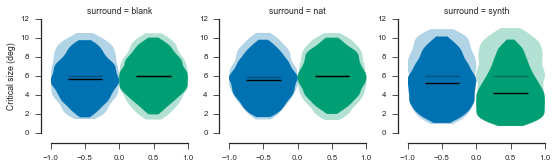

In [51]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_critical_scale', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_critical_scale', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical size (deg)')
sns.despine(offset=10, trim=True);

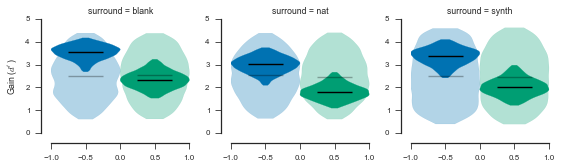

In [52]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_alpha', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_alpha', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Gain ($d^\prime$)')
sns.despine(offset=10, trim=True);

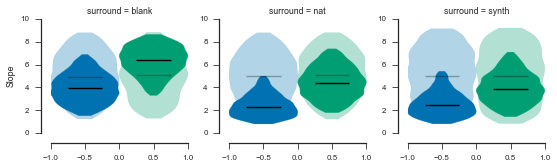

In [53]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  palette=pal,                  
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_beta', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_beta', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=10, trim=True);

So on the population level we see that there are some reasonable changes in the gain and slope parameters, but hardly anything for the critical scale. I'm not too sure why this is, but I suspect it's that there is not so much data that constrains the critical scale value. Why 0.5 still remains credible, I'm unsure.

# Performance variation for individual images

Pooling all data across observers, how much does performance vary over images?

- At a subset of patch sizes (e.g. smallest and largest)

In [54]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11981 entries, 0 to 14735
Data columns (total 25 columns):
cond               11981 non-null object
surround_cond      11981 non-null object
surround_source    11981 non-null object
oddball            11981 non-null int64
im_code            11981 non-null object
target_loc         11981 non-null int64
jitter_1           11981 non-null float64
jitter_2           11981 non-null float64
jitter_3           11981 non-null float64
subj               11981 non-null object
session            11981 non-null int64
eccent             11981 non-null int64
patch_size_px      11981 non-null int64
test_location      11981 non-null object
rand_seed          11981 non-null float64
trial              11981 non-null int64
response           11981 non-null object
rt                 11964 non-null float64
correct            11964 non-null float64
eye_invalid        11739 non-null float64
eye_sd_deg         11717 non-null float64
time_invalid       11739 non

In [55]:
# select subset of patch sizes:
mask = ((processed['patch_size'] == np.unique(processed['patch_size'])[0]) | \
       (processed['patch_size'] == np.unique(processed['patch_size'])[-1]))  & \
       (processed['cond'] == 'nat_v_synth')

subset = processed.loc[mask, :]
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 2 to 14735
Data columns (total 25 columns):
cond               1751 non-null object
surround_cond      1751 non-null object
surround_source    1751 non-null object
oddball            1751 non-null int64
im_code            1751 non-null object
target_loc         1751 non-null int64
jitter_1           1751 non-null float64
jitter_2           1751 non-null float64
jitter_3           1751 non-null float64
subj               1751 non-null object
session            1751 non-null int64
eccent             1751 non-null int64
patch_size_px      1751 non-null int64
test_location      1751 non-null object
rand_seed          1751 non-null float64
trial              1751 non-null int64
response           1751 non-null object
rt                 1747 non-null float64
correct            1747 non-null float64
eye_invalid        1751 non-null float64
eye_sd_deg         1751 non-null float64
time_invalid       1751 non-null float64
synth_err

In [56]:
subset.groupby(['cond', 'surround', 'patch_size']).size()

cond         surround  patch_size
nat_v_synth  blank     0.74          306
                       11.91         281
             nat       0.74          299
                       11.91         257
             synth     0.74          323
                       11.91         285
dtype: int64

In [57]:
subset.head()

,cond,surround_cond,surround_source,oddball,im_code,target_loc,jitter_1,jitter_2,jitter_3,subj,...,trial,response,rt,correct,eye_invalid,eye_sd_deg,time_invalid,synth_error,surround,patch_size
2,nat_v_synth,blank,na,0,i1260655983,3,-0.035395,0.034445,0.064320,S1,...,3,3,0.425034,1,0,0.063629,0,-26.310968,blank,0.74
5,nat_v_synth,blank,na,0,i1791248749,3,0.023180,0.040815,0.021867,S1,...,6,3,0.423361,1,0,0.077627,0,-28.651815,blank,0.74
7,nat_v_synth,blank,na,0,i2200881784,2,0.034811,0.013212,-0.023757,S1,...,8,2,0.400942,1,0,0.050182,0,-38.226549,blank,0.74
10,nat_v_synth,blank,na,1,i2155306779,3,0.083463,0.053688,0.096804,S1,...,11,3,0.494446,1,0,0.051668,0,-27.014443,blank,0.74
14,nat_v_synth,blank,na,0,istatic_outdoor_urban_city_street_coruna_spain...,2,0.088026,0.094539,0.017211,S1,...,15,1,0.451345,0,0,0.064876,0,-35.918774,blank,0.74


In [58]:
def sort_ims(cell):
    cell = helpers.binomial_binning(cell, 
                                    ['im_code', 'patch_size'], 
                                    rule_of_succession=True)
    # sort cells by average performance across conditions, assign number
    means = cell.groupby(['im_code']).mean()
    means.loc[:, 'im_code'] = means.index  # need to stick im_code back in. dumb.
    means = means.sort(columns='prop_corr')
    means.loc[:, 'im_num'] = np.arange(len(means))

    # cut out irrelevant cols:
    means = means.loc[:, ['im_code', 'im_num']]
    
    # re-merge im_num label with larger dataframe:
    merged = pd.merge(cell, means, on=['im_code'])
    return merged
    
grouped = subset.groupby(['patch_size'])
plot_dat = grouped.apply(sort_ims)
plot_dat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 172 entries, (0.74, 0) to (11.91, 80)
Data columns (total 10 columns):
im_code        172 non-null object
patch_size     172 non-null float64
n_successes    172 non-null float64
n_trials       172 non-null float64
prop_corr      172 non-null float64
ci_min         172 non-null float64
ci_max         172 non-null float64
error_min      172 non-null float64
error_max      172 non-null float64
im_num         172 non-null int64
dtypes: float64(8), int64(1), object(1)
memory usage: 14.6+ KB


In [59]:
plot_dat.head()

im_code  patch_size  \
patch_size                                                          
0.74       0  i05june05_static_street_boston_p1010885        0.74   
           1                              i1025035805        0.74   
           2                                 i1032358        0.74   
           3                               i103385035        0.74   
           4                              i1107916524        0.74   

              n_successes  n_trials  prop_corr    ci_min    ci_max  error_min  \
patch_size                                                                      
0.74       0            4        13   0.307692  0.099246  0.571858   0.208446   
           1            7        12   0.583333  0.307905  0.832512   0.275429   
           2            5        10   0.500000  0.212009  0.787991   0.287991   
           3            7        13   0.538462  0.276670  0.789055   0.261792   
           4            6        13   0.461538  0.210945  0.723330   0.250594   

              error_max  im_num  
patch_size                       
0.74       0   0.264166       9  
           1   0.249179      78  
           2   0.287991      58  
           3   0.250594      70  
           4   0.261792      51

In [60]:
# define plot funs
def plot_chance(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 99), (0.33, 0.33), ls='--', color='0.7')
    
def plot_errors(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col = args
    errors = np.vstack([data.loc[:, 'error_min'], 
                        data.loc[:, 'error_max']])

    plt.errorbar(data.loc[:, x_col], 
                 data.loc[:, y_col], 
                 yerr=errors,
                 **kwargs);      

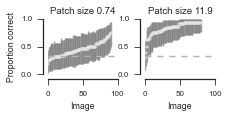

In [61]:
pal = sns.diverging_palette(220, 20, n=2)

g = sns.FacetGrid(plot_dat, 
#                   col='surround', 
                  col='patch_size', 
#                   marker='o',
#                   hue='patch_size', hue_kws={'marker': ['s', 'o']},
#                   palette=pal,
                  size=1.5)
g.map_dataframe(plot_errors, 'im_num', 'prop_corr',
                linestyle='none', 
                alpha=0.75,
                marker='o', 
                mfc='grey', ms=2, c='grey',
                mec='w', mew=1, capsize=0)
g.map_dataframe(plot_chance)

# aesthetics:
g.set_axis_labels('Image', 'Proportion correct')
g.set(xticks=np.linspace(0, 100, num=3), yticks=np.linspace(0, 1, num=3))

# set shorter titles for facets:
titles = ["Patch size 0.74",
          "Patch size 11.9"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.4, hspace=0.4)
sns.despine(offset=5, trim=True);

In [62]:
g.fig.set_figwidth(3.5)
print(g.fig.get_size_inches())
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'performance_by_images_nat_vs_synth.pdf'), bbox_inches='tight')

g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'performance_by_images_nat_vs_synth.svg'), bbox_inches='tight')

[ 3.5  1.5]


## Tail images at smallest size

In [63]:
# for smallest size

mask = (plot_dat['patch_size'] == 0.74)
blah = plot_dat.loc[mask, :].copy()

# easiest in small patch size:
blah.sort(columns='prop_corr', ascending=False).head()

im_code  patch_size  n_successes  \
patch_size                                                                   
0.74       67                         i2288435981        0.74            9   
           22                          i132672866        0.74            8   
           30                         i1659323957        0.74            9   
           56                         i2210603425        0.74            8   
           80  istatic_hotel_room_indoor_IMG_3264        0.74            8   

               n_trials  prop_corr    ci_min    ci_max  error_min  error_max  \
patch_size                                                                     
0.74       67        12   0.750000  0.482244  0.939782   0.267756   0.189782   
           22        11   0.727273  0.443905  0.933260   0.283368   0.205988   
           30        13   0.692308  0.428142  0.900754   0.264166   0.208446   
           56        12   0.666667  0.390257  0.890737   0.276409   0.224070   
           80        12   0.666667  0.390257  0.890737   0.276409   0.224070   

               im_num  
patch_size             
0.74       67      90  
           22      89  
           30      88  
           56      87  
           80      86

In [64]:
blah.sort(columns='prop_corr', ascending=True).head()

im_code  patch_size  n_successes  \
patch_size                                                                  
0.74       49                        i2155229819        0.74            2   
           74  ibarcelona_static_street_p9150528        0.74            3   
           31                        i1715062725        0.74            3   
           15                        i1229102713        0.74            3   
           72                         i245864757        0.74            3   

               n_trials  prop_corr    ci_min    ci_max  error_min  error_max  \
patch_size                                                                     
0.74       49        11   0.181818  0.025211  0.445016   0.156607   0.263198   
           74        13   0.230769  0.054861  0.484138   0.175909   0.253369   
           31        12   0.250000  0.060218  0.517756   0.189782   0.267756   
           15        12   0.250000  0.060218  0.517756   0.189782   0.267756   
           72        11   0.272727  0.066740  0.556095   0.205988   0.283368   

               im_num  
patch_size             
0.74       49       0  
           74       1  
           31       2  
           15       3  
           72       4

## Tail images at largest size

In [65]:
# for largest size:
mask = (plot_dat['patch_size'] == 11.91)
large_patch_subset = plot_dat.loc[mask, :].copy()

# easiest in size:
large_patch_subset.sort(columns='prop_corr', ascending=False).head()

im_code  patch_size  n_successes  n_trials  prop_corr  \
patch_size                                                                 
11.91      28  i1626133401       11.91           13        14   0.928571   
           26     i1508828       11.91           13        14   0.928571   
           40  i2190823731       11.91           12        13   0.923077   
           15  i1246368617       11.91           12        13   0.923077   
           29  i1739584262       11.91           12        13   0.923077   

                 ci_min    ci_max  error_min  error_max  im_num  
patch_size                                                       
11.91      28  0.752947  0.998054   0.175624   0.069483      80  
           26  0.752947  0.998054   0.175624   0.069483      79  
           40  0.735352  0.997892   0.187725   0.074815      78  
           15  0.735352  0.997892   0.187725   0.074815      77  
           29  0.735352  0.997892   0.187725   0.074815      73

In [66]:
large_patch_subset.sort(columns='prop_corr', ascending=True).head()

im_code  patch_size  n_successes  n_trials  prop_corr  \
patch_size                                                                 
11.91      32   i179901987       11.91            3        10   0.300000   
           31  i1777384643       11.91            5        13   0.384615   
           48  i2270031495       11.91            5        10   0.500000   
           2    i103134560       11.91            8        13   0.615385   
           18  i1300910455       11.91            8        13   0.615385   

                 ci_min    ci_max  error_min  error_max  im_num  
patch_size                                                       
11.91      32  0.074855  0.600094   0.225145   0.300094       0  
           31  0.151652  0.651124   0.232963   0.266509       1  
           48  0.212009  0.787991   0.287991   0.287991       2  
           2   0.348876  0.848348   0.266509   0.232963       3  
           18  0.348876  0.848348   0.266509   0.232963       4

## Relationship with saliency

In [67]:
# load image data
im_dat = pd.read_csv(os.path.join(top_dir, 'stimuli', 'experiment-9', 'final_ims', 'patch_info.csv'), index_col=False)
im_dat.rename(columns={'filename': 'im_code'}, inplace=True)
im_subset = im_dat.loc[:, ['im_code', 'middle_rms', 'sal_mid_mean']]
im_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 3 columns):
im_code         614 non-null object
middle_rms      614 non-null float64
sal_mid_mean    614 non-null float64
dtypes: float64(2), object(1)
memory usage: 19.2+ KB


In [68]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11981 entries, 0 to 14735
Data columns (total 25 columns):
cond               11981 non-null object
surround_cond      11981 non-null object
surround_source    11981 non-null object
oddball            11981 non-null int64
im_code            11981 non-null object
target_loc         11981 non-null int64
jitter_1           11981 non-null float64
jitter_2           11981 non-null float64
jitter_3           11981 non-null float64
subj               11981 non-null object
session            11981 non-null int64
eccent             11981 non-null int64
patch_size_px      11981 non-null int64
test_location      11981 non-null object
rand_seed          11981 non-null float64
trial              11981 non-null int64
response           11981 non-null object
rt                 11964 non-null float64
correct            11964 non-null float64
eye_invalid        11739 non-null float64
eye_sd_deg         11717 non-null float64
time_invalid       11739 non

In [69]:
# binomial proportions for each image, across subjects, blurs and surround, in each patch size:
image_perf = helpers.binomial_binning(processed, 
                                      ['im_code', 'patch_size'], 
                                      rule_of_succession=True)
image_perf.head()

,im_code,patch_size,n_successes,n_trials,prop_corr,ci_min,ci_max,error_min,error_max
0,i05june05_static_street_boston_p1010764,11.91,16,25,0.640000,0.446780,0.812007,0.193220,0.172007
1,i05june05_static_street_boston_p1010785,5.95,13,21,0.619048,0.407811,0.808810,0.211236,0.189762
2,i05june05_static_street_boston_p1010800,5.95,10,17,0.588235,0.354346,0.802466,0.233889,0.214231
3,i05june05_static_street_boston_p1010806,5.95,13,18,0.722222,0.501007,0.896864,0.221215,0.174642
4,i05june05_static_street_boston_p1010808,8.93,14,21,0.666667,0.457211,0.846091,0.209456,0.179424


In [70]:
image_perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 9 columns):
im_code        614 non-null object
patch_size     614 non-null float64
n_successes    614 non-null float64
n_trials       614 non-null float64
prop_corr      614 non-null float64
ci_min         614 non-null float64
ci_max         614 non-null float64
error_min      614 non-null float64
error_max      614 non-null float64
dtypes: float64(8), object(1)
memory usage: 48.0+ KB


In [71]:
# merge in the saliency values on image code (drops one case, not sure why):
with_sal = pd.merge(image_perf, im_subset, on='im_code')
with_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 11 columns):
im_code         614 non-null object
patch_size      614 non-null float64
n_successes     614 non-null float64
n_trials        614 non-null float64
prop_corr       614 non-null float64
ci_min          614 non-null float64
ci_max          614 non-null float64
error_min       614 non-null float64
error_max       614 non-null float64
middle_rms      614 non-null float64
sal_mid_mean    614 non-null float64
dtypes: float64(10), object(1)
memory usage: 57.6+ KB


In [72]:
# z-score empirical saliency within each patch size:
def norm_func(dat):
    dat.loc[:, 'sal_mid_mean_normed'] = ((dat.loc[:, 'sal_mid_mean'] - 
                                          dat.loc[:, 'sal_mid_mean'].mean()) / 
                                          dat.loc[:, 'sal_mid_mean'].std())
    return dat

with_sal = with_sal.groupby(['patch_size']).apply(norm_func)
with_sal['sal_mid_mean_normed'].describe()

count    6.140000e+02
mean    -4.339634e-17
std      9.950940e-01
min     -2.257390e+00
25%     -7.704082e-01
50%     -1.947922e-01
75%      6.097306e-01
max      3.384901e+00
Name: sal_mid_mean_normed, dtype: float64

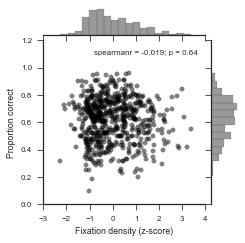

In [73]:
# plot correlation between saliency and proportion correct:
g = sns.jointplot('sal_mid_mean_normed', 'prop_corr', data=with_sal,
                  stat_func=spearmanr,
                  size=3.5, color='black', alpha=0.5)
g.set_axis_labels('Fixation density (z-score)', 'Proportion correct');             

In [74]:
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       'explore_saliency.pdf'), bbox_inches='tight')